<a href="https://colab.research.google.com/github/HowardHNguyen/Python/blob/main/User_Behavior_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Methodology**

Data set exploration and cleaning
Create a cohort and conduct cohort analysis
Visualize the cohort analysis results

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/online_retail_uci.xlsx')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# As it is shown, there are eight features in the data frame. I won’t use all the features. 
#Only quantity, invoice date, unit price, customer ID are needed.

In [ ]:
df.shape

(541909, 8)

In [ ]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# drop cusomter ID as it missed 135080 ids.
df1 = df.dropna(subset=['CustomerID'])
df1.shape

(406829, 8)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [ ]:
df1.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
# Create Cohort & Conduct Cohort Analysis
# Before creating cohorts, I need to munge two columns regarding months: one is invoice month, the other is cohort month.
# With the helper function “get_month”, I am able to create the invoice month column first.
def get_month(x):
  return dt.datetime(x.year, x.month, 1)

df1['InvoiceMonth'] = df1['InvoiceDate'].apply(get_month)
df1['CohortMonth'] = df1.groupby('CustomerID')['InvoiceMonth'].transform('min')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#And for the cohort month, it is the first month for the specific user ID when that user shopped at this online retailer. 
#The groupby and transform are used for creating the cohort month.
#Finally, I created a cohort index for each row. The cohort index is the month difference between invoice month and cohort month for each row. 
#By doing the deduction, I am able to know the month lapse between that specific transaction and the first transaction that user made on the website.

In [ ]:
def get_date(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
invoice_year, invoice_month, _ = get_date(df1, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date(df1, 'CohortMonth')
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
df1['CohortIndex'] = year_diff * 12 + month_diff + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#Create 1st Cohort: User number & Retention Rate
#The first cohort I use here is the number of active users. I use groupby and pivot table functions.

In [ ]:
cohort_data = df1.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_count = cohort_data.pivot_table(index = 'CohortMonth',
                                       columns = 'CohortIndex',
                                       values = 'CustomerID')
cohort_count

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#From the result above, the first column in the chart is active user number on that specific month, and the following columns 
#show how the many remaining users are still using the service on the second, third, and fourth month.
#The 13th column and 2010–12–1 row means 260 users out of 948 users were still buying things after the 13 months from 2010/12/1.
#Based on this data frame, I can further transform the absolute number into percentage to showcase the retention rate using the code below.

In [ ]:
cohort_size = cohort_count.iloc[:,0]
retention = cohort_count.divide(cohort_size, axis = 0)
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#The first column is no doubt 100% retention rate, and with time going by, the retention rate would drop.
#Finally, I am able to visualize the retention data frame with Seaborn heatmap to make the result more understandable.

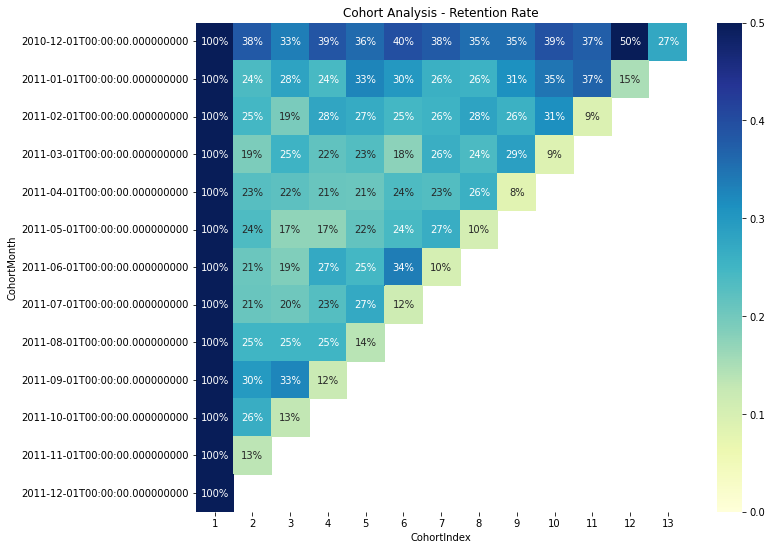

In [ ]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Retention Rate')
sns.heatmap(data = retention, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.5,
            cmap = "YlGnBu")
plt.show()

In [ ]:
#From the graph, it can be concluded that on 2011/11 some strategies might be implemented to increase the return users. 
#About 50% of user from 2010/12 cohort return on 2011/11. 
#Marketing analysts or product analysts might further investigate if some campaigns or feature changes that lead to the higher retention.

In [ ]:
# Create the 2nd Cohort: Average Quantity Sold
# Beside retention metrics, there are many metrics the power of cohort can be utilized. 
# In the 2nd cohort, I show the average quantity on the time series basis, seeing how the purchase quantity changes along with months.

In [ ]:
cohort_data2 = df1.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].mean().reset_index()
average_quantity  = cohort_data2.pivot_table(index = 'CohortMonth',
                                            columns = 'CohortIndex',
                                       values = 'Quantity').round(1)
average_quantity

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.0,14.6,15.0,14.8,12.9,14.3,15.2,14.8,16.7,16.7,17.3,12.8,14.8
2011-01-01,10.0,12.6,12.3,10.9,12.2,14.9,14.2,14.4,11.4,9.9,9.1,9.5,NaN
2011-02-01,10.8,12.1,18.6,12.0,11.1,11.4,13.3,12.4,10.3,11.9,12.6,NaN,NaN
2011-03-01,9.8,9.9,12.2,9.5,13.6,12.3,13.2,12.2,10.5,8.9,NaN,NaN,NaN
2011-04-01,9.8,10.1,9.4,11.6,11.5,8.2,9.7,9.3,7.3,NaN,NaN,NaN,NaN
2011-05-01,10.9,9.0,13.9,11.8,10.9,8.7,10.1,7.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.3,13.7,10.5,13.3,10.2,9.8,9.3,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.7,12.7,7.1,7.8,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.9,6.0,5.3,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


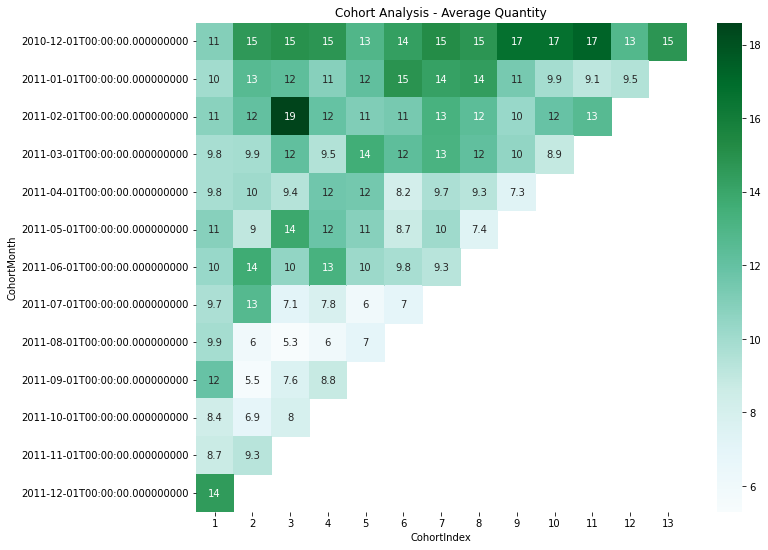

In [ ]:
# Visualize:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Quantity')
sns.heatmap(data = average_quantity, 
            annot = True, 
            cmap = "BuGn")
plt.show()

In [ ]:
# It is observed that within the recent cohort/month, the average quantity on the website was facing a decline. 
# It is a warning signal that users stop buying merchandise on the website. The reason needs further investigation.

In [ ]:
#Create the 3rd Cohort: Average Sales
#Before creating this cohort, I munged the total sales column by multiplying quantity and unit price. 
#And the following step is quite similar to the 2nd cohort.

In [ ]:
df1['TotalSale'] = df1['Quantity'] * df1['UnitPrice']
cohort_data3 = df1.groupby(['CohortMonth', 'CohortIndex'])['TotalSale'].mean().reset_index()
average_sales  = cohort_data3.pivot_table(index = 'CohortMonth',
                                           columns = 'CohortIndex',
                                      values = 'TotalSale').round(1)
average_sales

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,20.7,25.0,25.1,25.0,19.9,25.5,26.5,25.4,26.0,31.1,30.6,22.2,24.7
2011-01-01,18.4,23.5,20.3,17.5,21.5,25.4,24.4,24.5,18.7,20.1,18.7,18.4,NaN
2011-02-01,17.0,17.0,19.3,18.8,16.1,15.1,21.6,20.9,17.5,20.6,21.5,NaN,NaN
2011-03-01,17.0,17.9,21.5,17.0,19.2,18.1,21.7,17.3,15.4,11.4,NaN,NaN,NaN
2011-04-01,16.4,20.2,18.8,18.4,18.6,14.2,14.6,15.3,11.8,NaN,NaN,NaN,NaN
2011-05-01,19.0,15.7,21.2,19.4,17.8,14.1,16.1,13.3,NaN,NaN,NaN,NaN,NaN
2011-06-01,16.4,14.5,19.0,19.8,15.0,15.9,12.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,13.1,21.2,11.4,12.4,10.5,11.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,16.1,11.9,11.5,14.4,15.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


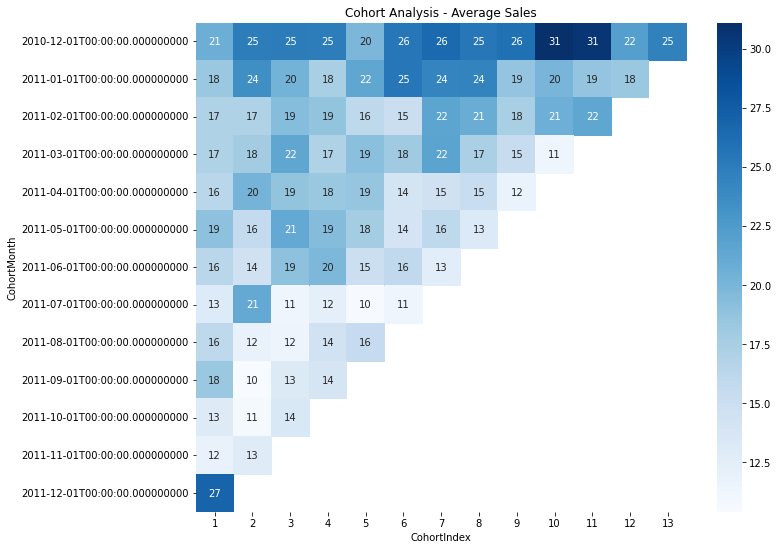

In [ ]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Sales')
sns.heatmap(data = average_sales, 
            annot = True, 
            cmap = "Blues")
plt.show()

In [ ]:
#The situation for average sales is parallel with the average quantity, which the retailer faces a significant decline in recent months. 
#How to sustain the buying behaviors will be the issue with thinking for the product/marketing team.